In [1]:
%matplotlib inline

import pandas
import seaborn

seaborn.set()

In [2]:
!pwd

/home/jng/devel/peakrisk/posts


In [3]:
infile = '../files/light.csv'

In [119]:
!scp 192.168.0.133:Adafruit_Python_BMP/light.csv .
!mv light.csv ../files

light.csv                                     100%  653KB 652.7KB/s   00:00    


In [120]:
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

In [121]:
data.describe()

,temp,pressure,altitude,sealevel_pressure
count,9781.000000,9781.000000,9781.000000,9781.000000
mean,28.850588,101406.583376,-21.684193,101829.514058
std,4.317209,4812.524976,350.931165,3291.566903
min,-27.100000,28421.000000,-2749.583598,37537.000000
25%,28.000000,101683.000000,-47.430304,101685.000000
50%,28.600000,101760.000000,-36.235947,101764.000000
75%,29.300000,101896.000000,-29.845631,101898.000000
max,162.900000,128808.000000,7610.794710,139326.000000


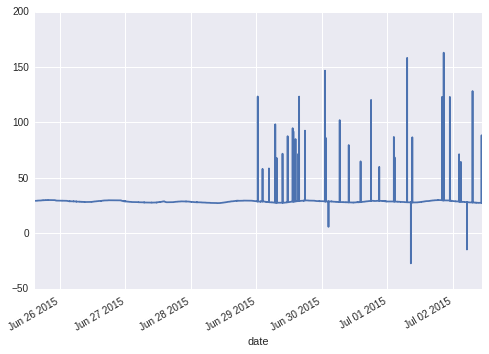

In [122]:
#data.plot()
data.temp.plot()

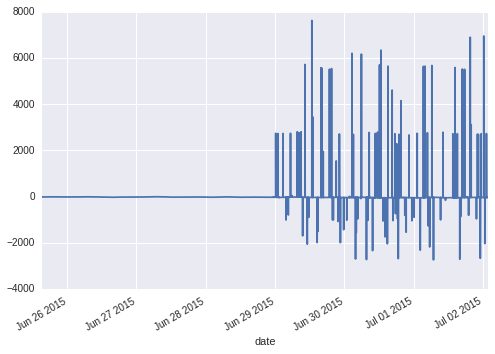

In [112]:
data.altitude.plot()

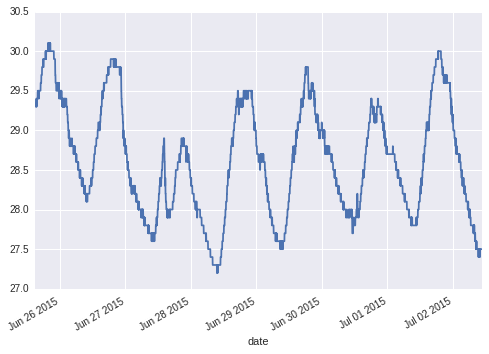

In [123]:
data.temp[(data.temp < 50.0) & (data.temp > 15.0)].plot()

In [104]:
def spot_outliers(series):
    
    delta = series - series.shift()
    delta2 = series - series.shift(-1)
    
    std = series.std()
    
    bad1 = delta.abs() > std
    bad2 = delta2.abs() > std
    
    #return bad1.cumsum()
    
    #print(bad1.describe())
    #print(bad2.describe())

    return bad1 & bad2

outliers = spot_outliers(data)

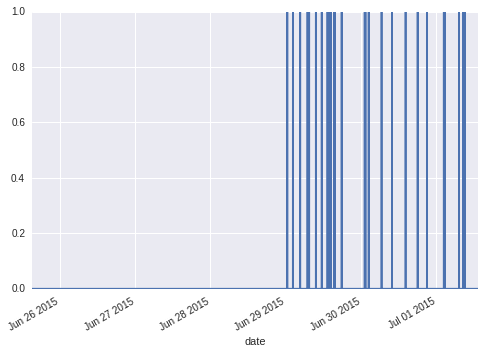

In [105]:
outliers.temp.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c73aa7080>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c73990ef0>], dtype=object)

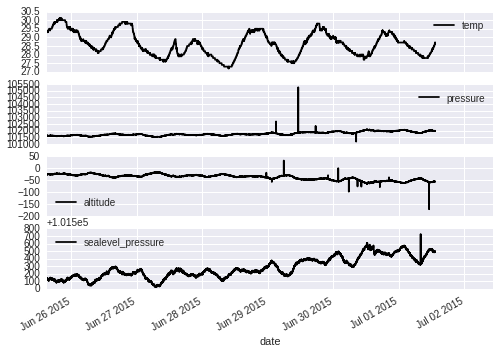

In [124]:
data[~outliers].plot(subplots=True)

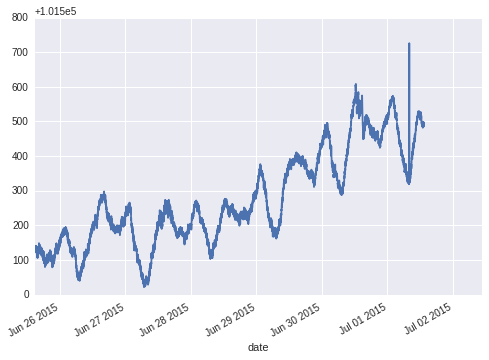

In [125]:
data[~outliers].sealevel_pressure.plot()

In [147]:
def smooth(data):
    
    means = data.mean()
    sds = data.std()
    
    delta = data - data.shift()
    
    good = delta[abs(delta) < sds]
    
    return delta.where(good, 0.0)

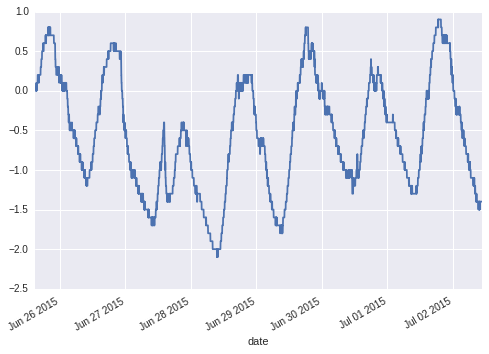

In [150]:
smooth(data).temp.cumsum().plot()

In [170]:
sdata = smooth(data)

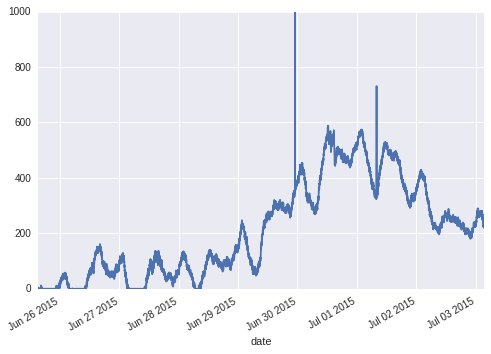

In [174]:
sdata.sealevel_pressure.cumsum().clip(0, 1000).plot()

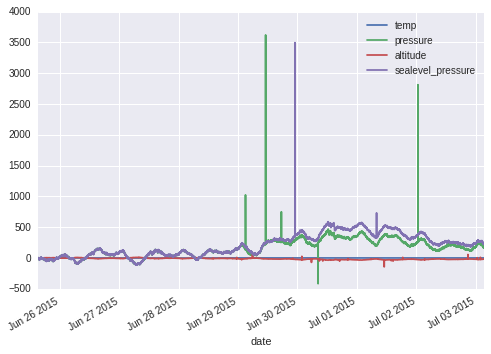

In [169]:
smooth(data).cumsum().plot()

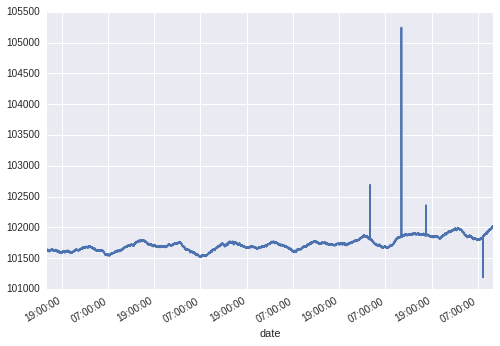

In [166]:
data[~outliers].pressure.plot()

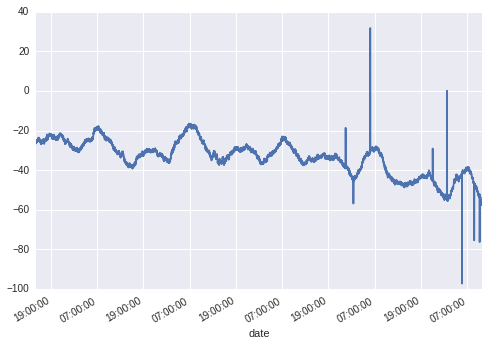

In [81]:
data[~outliers].altitude.plot()

temp                     28.792789
pressure             101483.273579
altitude                -24.925212
sealevel_pressure    101752.967119
dtype: float64


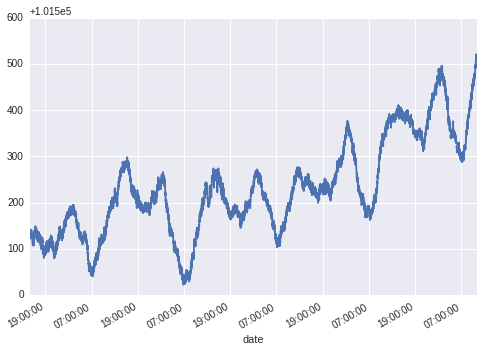

In [50]:
data[~spot_outliers(data)].sealevel_pressure.plot()

In [65]:
data[outliers].head()

,temp,pressure,altitude,sealevel_pressure
date,,,,
2015-06-25 15:07:37.174400,NaN,NaN,NaN,NaN
2015-06-25 15:08:37.290769,NaN,NaN,NaN,NaN
2015-06-25 15:09:37.406928,NaN,NaN,NaN,NaN
2015-06-25 15:10:37.523022,NaN,NaN,NaN,NaN
2015-06-25 15:11:37.638969,NaN,NaN,NaN,NaN


In [66]:
data.head()

,temp,pressure,altitude,sealevel_pressure
date,,,,
2015-06-25 15:07:37.174400,29.3,101637,-25.777027,101637
2015-06-25 15:08:37.290769,29.3,101642,-26.524440,101640
2015-06-25 15:09:37.406928,29.3,101643,-25.943123,101637
2015-06-25 15:10:37.523022,29.3,101644,-25.777027,101637
2015-06-25 15:11:37.638969,29.3,101634,-26.441397,101637


In [71]:
data[outliers].temp.dropna().head(100)

date
2015-06-29 00:30:04.757425    123.4
2015-06-29 00:31:04.825191     28.7
2015-06-29 02:16:16.421378     58.1
2015-06-29 02:17:16.537159     28.7
2015-06-29 04:36:31.999731     58.5
2015-06-29 04:37:32.117171     28.1
2015-06-29 06:55:47.389789     98.3
2015-06-29 06:56:47.509126     27.7
2015-06-29 07:27:50.925301     67.9
2015-06-29 07:28:51.041155     27.6
2015-06-29 09:35:04.905765     71.8
2015-06-29 09:36:05.024312     27.5
2015-06-29 11:27:17.365401     87.6
2015-06-29 11:28:17.481124     28.0
2015-06-29 13:17:29.549340     94.8
2015-06-29 13:18:29.666808     28.7
2015-06-29 13:33:31.345615     91.9
2015-06-29 13:34:31.441210     28.6
2015-06-29 13:49:33.137824     67.4
2015-06-29 13:50:33.253194     28.6
2015-06-29 14:20:36.557338     85.0
2015-06-29 14:21:36.675298     28.8
2015-06-29 15:23:43.578008     71.7
2015-06-29 15:24:43.693164     29.1
2015-06-29 15:39:45.370125    123.3
2015-06-29 15:40:45.441188     29.1
2015-06-29 17:47:59.445202     92.6
2015-06-29 17:48:59.562

In [64]:
data[outliers]

,temp,pressure,altitude,sealevel_pressure
date,,,,
2015-06-25 15:07:37.174400,NaN,NaN,NaN,NaN
2015-06-25 15:08:37.290769,NaN,NaN,NaN,NaN
2015-06-25 15:09:37.406928,NaN,NaN,NaN,NaN
2015-06-25 15:10:37.523022,NaN,NaN,NaN,NaN
2015-06-25 15:11:37.638969,NaN,NaN,NaN,NaN
2015-06-25 15:12:37.755075,NaN,NaN,NaN,NaN
2015-06-25 15:13:37.817112,NaN,NaN,NaN,NaN
2015-06-25 15:14:37.933191,NaN,NaN,NaN,NaN
2015-06-25 15:15:38.049267,NaN,NaN,NaN,NaN


temp                     28.792789
pressure             101483.273579
altitude                -24.925212
sealevel_pressure    101752.967119
dtype: float64


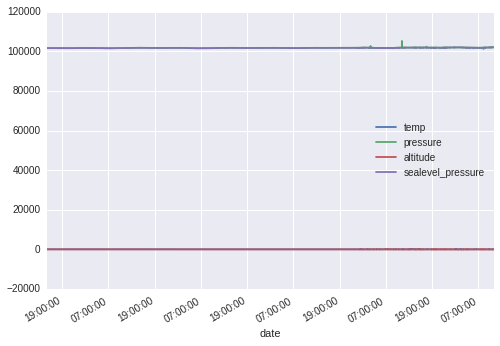

In [51]:
data[~spot_outliers(data)].plot()

In [39]:
data[~mask].describe()

,temp,pressure,altitude,sealevel_pressure
count,6928.000000,6928.000000,6928.000000,6928.000000
mean,28.775375,101501.169169,-24.226710,101752.912529
std,3.277376,3732.934051,253.031530,2540.752829
min,5.800000,37993.000000,-2736.815676,37537.000000
25%,28.000000,101656.000000,-38.558727,101660.000000
50%,28.600000,101715.000000,-32.501823,101717.000000
75%,29.300000,101788.000000,-27.686978,101789.000000
max,146.700000,128808.000000,7610.794710,139326.000000


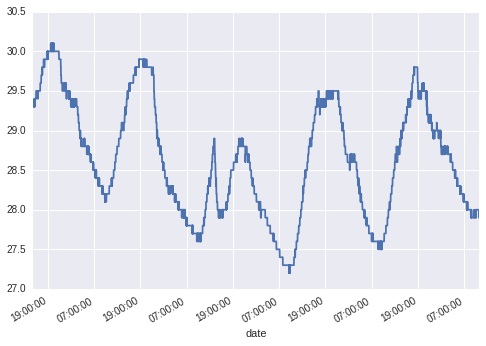

In [31]:
data.temp[spot_outliers(data.temp)].plot()

In [23]:
data.temp[data.temp > 50.0]

date
2015-06-29 00:30:04.757425    123.4
2015-06-29 02:16:16.421378     58.1
2015-06-29 04:36:31.999731     58.5
2015-06-29 06:55:47.389789     98.3
2015-06-29 07:27:50.925301     67.9
2015-06-29 09:35:04.905765     71.8
2015-06-29 11:27:17.365401     87.6
2015-06-29 13:17:29.549340     94.8
2015-06-29 13:33:31.345615     91.9
2015-06-29 13:49:33.137824     67.4
2015-06-29 14:20:36.557338     85.0
2015-06-29 15:23:43.578008     71.7
2015-06-29 15:39:45.370125    123.3
2015-06-29 17:47:59.445202     92.6
Name: temp, dtype: float64

In [24]:
bad = data.temp[data.temp > 50.0]
bad.describe()

count     14.000000
mean      85.164286
std       20.949192
min       58.100000
25%       68.850000
50%       86.300000
75%       94.250000
max      123.400000
Name: temp, dtype: float64

In [26]:
data.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48b7862358>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b7772278>], dtype=object)

In [27]:
mask = data.temp < 50.0

mask = mask & (abs(data.altitude) < 100.0)

good = data[mask]

In [28]:
good.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48b798c5f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b752b588>], dtype=object)

In [29]:
good.describe()

              temp       pressure     altitude  sealevel_pressure
count  5997.000000    5997.000000  5997.000000        5997.000000
mean     28.644489  101682.101884   -31.575287      101680.632816
std       0.759484    1541.214027     7.020223        1280.501740
min      27.200000   37993.000000   -56.873967       49539.000000
25%      28.000000  101642.000000   -35.157337      101643.000000
50%      28.600000  101702.000000   -31.339822      101702.000000
75%      29.400000  101748.000000   -26.441397      101748.000000
max      30.100000  128808.000000    31.768412      121592.000000

In [30]:
data.describe()

              temp       pressure     altitude  sealevel_pressure
count  6033.000000    6033.000000  6033.000000        6033.000000
mean     28.775535  101546.593569   -22.896557      101749.929057
std       2.986311    3129.776450   226.384162        1972.425764
min      27.200000   28421.000000 -2067.737364       49539.000000
25%      28.000000  101642.000000   -35.240311      101643.000000
50%      28.600000  101702.000000   -31.339822      101702.000000
75%      29.400000  101748.000000   -26.358353      101749.000000
max     123.400000  128808.000000  7610.794710      139326.000000

In [31]:
data.count()

temp                 6033
pressure             6033
altitude             6033
sealevel_pressure    6033
dtype: int64

In [32]:
mask.value_counts()

True     5997
False      36
dtype: int64

In [33]:
data.temp[mask == False]

date
2015-06-29 00:15:03.099947     28.7
2015-06-29 00:30:04.757425    123.4
2015-06-29 01:00:07.986653     28.6
2015-06-29 02:16:16.421378     58.1
2015-06-29 02:47:19.895202     28.6
2015-06-29 03:49:26.791876     28.3
2015-06-29 04:36:31.999731     58.5
2015-06-29 05:22:37.055336     27.9
2015-06-29 06:55:47.389789     98.3
2015-06-29 07:27:50.925301     67.9
2015-06-29 07:43:52.672374     27.6
2015-06-29 08:15:56.230414     27.6
2015-06-29 09:03:01.390829     27.6
2015-06-29 09:35:04.905765     71.8
2015-06-29 10:24:10.334328     27.7
2015-06-29 11:11:15.557277     27.9
2015-06-29 11:27:17.365401     87.6
2015-06-29 11:43:19.113136     28.0
2015-06-29 12:46:26.116145     28.5
2015-06-29 13:02:27.905121     28.6
2015-06-29 13:17:29.549340     94.8
2015-06-29 13:33:31.345615     91.9
2015-06-29 13:49:33.137824     67.4
2015-06-29 14:20:36.557338     85.0
2015-06-29 14:36:38.309515     28.9
2015-06-29 14:52:40.113594     29.0
2015-06-29 15:23:43.578008     71.7
2015-06-29 15:39:45.370

In [34]:
good.temp[mask == False]

Series([], Name: temp, dtype: float64)

In [35]:
type(good)

pandas.core.frame.DataFrame

In [44]:
data[data.temp > 50.0]

                             temp  pressure     altitude  sealevel_pressure
date                                                                       
2015-06-29 00:30:04.757425  123.4    101808   -40.134605             101811
2015-06-29 02:16:16.421378   58.1    101850   -43.368556             101838
2015-06-29 04:36:31.999731   58.5     28421  -806.764055             101727
2015-06-29 06:55:47.389789   98.3    101695   -30.343719             101690
2015-06-29 07:27:50.925301   67.9    101666   -29.430540             101675
2015-06-29 09:35:04.905765   71.8    101779 -1707.795743             101782
2015-06-29 11:27:17.365401   87.6    101850   -43.865998             101853
2015-06-29 13:17:29.549340   94.8    101882   -46.104193             101883
2015-06-29 13:33:31.345615   91.9    101880   -45.855528             101880
2015-06-29 13:49:33.137824   67.4    101884   -46.850151             101890
2015-06-29 14:20:36.557338   85.0    101894   -46.684387             101887
2015-06-29 1

In [45]:
data[data.altitude > 0.0]

                            temp  pressure     altitude  sealevel_pressure
date                                                                      
2015-06-29 00:15:03.099947  28.7     49788  2728.365527             133102
2015-06-29 01:00:07.986653  28.6     49695  2714.956421             133319
2015-06-29 02:47:19.895202  28.6     49721  2718.988121             133202
2015-06-29 05:22:37.055336  27.9     49250  2729.020100             139309
2015-06-29 05:53:40.477528  27.8     54037    31.768412             101697
2015-06-29 07:43:52.672374  27.6     49055  2795.798273             133472
2015-06-29 08:15:56.230414  27.6     49039  2758.521361             101702
2015-06-29 09:03:01.390829  27.6     49033  2792.613214             133667
2015-06-29 10:24:10.334328  27.7     49095  5708.784518             139326
2015-06-29 12:46:26.116145  28.5    101870  7610.794710             101862
2015-06-29 13:02:27.905121  28.6    101878  3444.553889             101875
2015-06-29 15:55:47.11346

In [46]:
data[data.pressure > 110000.0]

                            temp  pressure     altitude  sealevel_pressure
date                                                                      
2015-06-29 00:00:01.421409  28.8    118018   -39.056399             101791
2015-06-29 02:31:18.059312  28.6    114827   -42.373601             101837
2015-06-29 03:49:26.791876  28.3    115708 -1022.457395             101762
2015-06-29 04:20:30.231987  28.1    114477   -33.497720             101734
2015-06-29 06:08:42.060109  27.8    114872   -29.430540             101679
2015-06-29 10:08:08.582132  27.6    128808   -40.051670             101813
2015-06-29 18:39:35.176405  29.8    112674   -44.031806             101850
2015-06-29 19:56:43.548595  29.5    115516 -1016.637971             101847
2015-06-29 20:12:45.188962  29.5    115597 -1019.056818             101848
2015-06-29 20:59:50.346986  29.5    114416   -41.710245             101828

In [49]:
data.diff()[:100].temp.plot()